In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import time

In [2]:
txn = pd.read_csv("/Users/judepereira/Downloads/ieee-fraud-detection/train_transaction.csv")
idm = pd.read_csv("/Users/judepereira/Downloads/ieee-fraud-detection/train_identity.csv")

# derive “day” from TransactionDT, then drop the raw column
txn["day"] = (txn["TransactionDT"] // (3600 * 24)).astype(int)
txn.drop("TransactionDT", axis=1, inplace=True)

# merge identity info into transaction table
df = txn.merge(idm, on="TransactionID", how="left")
df.drop("TransactionID", axis=1, inplace=True)

In [3]:
print(df.shape)

(590540, 433)


In [3]:
# re-compute missing‐% for each V-column
vcols    = [c for c in df.columns if c.startswith("V")]
v_nulls  = df[vcols].isna().mean() * 100

# find V-columns with more than 10% missing values
cols_10 = v_nulls[v_nulls >= 10].index.tolist()

# and drop them!
df.drop(columns=cols_10, inplace=True)

In [4]:
print(df.shape)

(590540, 180)


In [5]:
from sklearn.preprocessing import LabelEncoder

id_cols = [c for c in idm.columns if c.startswith("id_")]

# keep only low‐cardinality IDs (<=50 unique), drop the rest
keep_ids = [c for c in id_cols if df[c].nunique(dropna=False) <= 50]
drop_ids = [c for c in id_cols if c not in keep_ids]
df.drop(columns=drop_ids, inplace=True)

# fill & label‐encode the kept ID features
for c in keep_ids:
    df[c] = df[c].fillna("MISSING")
    df[c] = LabelEncoder().fit_transform(df[c].astype(str))

In [6]:
print(df.shape)

(590540, 162)


In [7]:
from sklearn.impute import SimpleImputer

# numeric imputation (median) – exclude the target “isFraud”
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
num_cols.remove("isFraud")

imputer = SimpleImputer(strategy="median")
df[num_cols] = imputer.fit_transform(df[num_cols])

In [8]:
# for remaining categoricals, one‐hot encode small‐cardinaliy ones
cat_cols = df.select_dtypes(include=["object"]).columns.tolist()
# e.g. “ProductCD”, “MISSING” placeholders, etc.
for c in cat_cols:
    n_uniq = df[c].nunique()
    if n_uniq <= 10:
        dummies = pd.get_dummies(df[c], prefix=c, drop_first=True)
        df = pd.concat([df.drop(c, axis=1), dummies], axis=1)
    else:
        # high‐cardinality strings you can label‐encode or drop
        df[c] = LabelEncoder().fit_transform(df[c].astype(str))

In [9]:
print(df.shape)

(590540, 170)


In [32]:
# splitting & evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import (average_precision_score, roc_auc_score)

In [11]:
# all non‐fraud examples
df_norm = df[df.isFraud == 0].copy()
# all fraud examples
df_fraud = df[df.isFraud == 1].copy()

# hold out 20% of normals for CV
norm_train, norm_cv = train_test_split(
    df_norm, test_size=0.2, random_state=42
)

# CV set = held‐out normals + all frauds
df_cv = pd.concat([norm_cv, df_fraud], axis=0)
y_cv  = df_cv["isFraud"].values

# drop labels for modeling
X_train = norm_train.drop("isFraud", axis=1).values
X_cv    = df_cv.drop("isFraud", axis=1).values

print("→ Training on normals only:", X_train.shape)
print("→ CV set (normals+fraud):", X_cv.shape)

→ Training on normals only: (455901, 169)
→ CV set (normals+fraud): (134639, 169)


In [12]:
df_cv.shape

(134639, 170)

In [13]:
# Optional standardization
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_cv    = scaler.transform(X_cv)    

In [14]:
# Convert to PyTorch tensors
x_train = torch.FloatTensor(X_train)
x_valid = torch.FloatTensor(X_cv)
y_valid = torch.FloatTensor(y_cv)

In [15]:
# The output must match the input for autoencoders

class FraudDatasetUnsupervised(Dataset):
    
    def __init__(self, x,output=True):
        'Initialization'
        self.x = x
        self.output = output

    def __len__(self):
        'Returns the total number of samples'
        return len(self.x)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample index
        item = self.x[index]
        if self.output:
            return item, item
        else:
            return item

In [16]:
training_set = FraudDatasetUnsupervised(x_train)
valid_set = FraudDatasetUnsupervised(x_valid)

In [17]:
# Build Pytorch loaders
BATCH_SIZE = 64

train_loader = DataLoader(training_set, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(valid_set,   batch_size=BATCH_SIZE, shuffle=False)

In [18]:
# Our autoencoder consists of the following layers:
# A first input layer with ReLu activation (input_size, intermediate_size)
# A second layer with ReLu activation (intermediate_size, code_size)
# A third layer with ReLu activation (code_size, intermediate_size)
# An output layer with linear activation (intermediate_size, input_size)

class SimpleAutoencoder(torch.nn.Module):
    
        def __init__(self, input_size, intermediate_size, code_size):
            super(SimpleAutoencoder, self).__init__()
            # parameters
            self.input_size = input_size
            self.intermediate_size = intermediate_size           
            self.code_size  = code_size
            
            self.relu = torch.nn.ReLU()   
            
            #encoder
            self.fc1 = torch.nn.Linear(self.input_size, self.intermediate_size)
            self.fc2 = torch.nn.Linear(self.intermediate_size, self.code_size)
            
            #decoder 
            self.fc3 = torch.nn.Linear(self.code_size, self.intermediate_size)            
            self.fc4 = torch.nn.Linear(self.intermediate_size, self.input_size)
            
            
        def forward(self, x):
            
            hidden = self.fc1(x)
            hidden = self.relu(hidden)
            
            code = self.fc2(hidden)
            code = self.relu(code)
 
            hidden = self.fc3(code)
            hidden = self.relu(hidden)
            
            output = self.fc4(hidden)
            #linear activation in final layer)            
            
            return output

In [19]:
criterion = torch.nn.MSELoss()

In [20]:
def per_sample_mse(model, generator):
    
    model.eval()
    criterion = torch.nn.MSELoss(reduction="none")
    batch_losses = []
    
    for x_batch, y_batch in generator:
        # Forward pass
        y_pred = model(x_batch)
        # Compute Loss
        loss = criterion(y_pred.squeeze(), y_batch)
        loss_app = list(torch.mean(loss,axis=1).detach().cpu().numpy())
        batch_losses.extend(loss_app)
    
    return batch_losses

In [21]:
model = SimpleAutoencoder(x_train.shape[1], 100, 20)
losses = per_sample_mse(model, val_loader)

In [22]:
print(losses[0:5])
print(np.mean(losses))

[np.float32(0.6189681), np.float32(1.467065), np.float32(0.111749336), np.float32(0.30326587), np.float32(1.0537688)]
1.2550507


In [23]:
def evaluate_model(model,generator,criterion):
    model.eval()
    batch_losses = []
    for x_batch, y_batch in generator:
        # Forward pass
        y_pred = model(x_batch)
        # Compute Loss
        loss = criterion(y_pred.squeeze(), y_batch)
        batch_losses.append(loss.item())
    mean_loss = np.mean(batch_losses)    
    return mean_loss

In [24]:
class EarlyStopping:
    
    def __init__(self, patience=2, verbose=False):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = np.inf
    
    def continue_training(self,current_score):
        if self.best_score > current_score:
            self.best_score = current_score
            self.counter = 0
            if self.verbose:
                print("New best score:", current_score)
        else:
            self.counter+=1
            if self.verbose:
                print(self.counter, " iterations since best score.")
                
        return self.counter <= self.patience 

In [25]:
def training_loop(model,training_generator,valid_generator,optimizer,criterion,max_epochs=100,apply_early_stopping=True,patience=2,verbose=False):
    #Setting the model in training mode
    model.train()

    if apply_early_stopping:
        early_stopping = EarlyStopping(verbose=verbose,patience=patience)
    
    all_train_losses = []
    all_valid_losses = []
    
    #Training loop
    start_time=time.time()
    for epoch in range(max_epochs):
        model.train()
        train_loss=[]
        for x_batch, y_batch in training_generator:
            optimizer.zero_grad()
            # Forward pass
            y_pred = model(x_batch)
            # Compute Loss
            loss = criterion(y_pred.squeeze(), y_batch)
            # Backward pass
            loss.backward()
            optimizer.step()   
            train_loss.append(loss.item())
        
        #showing last training loss after each epoch
        all_train_losses.append(np.mean(train_loss))
        if verbose:
            print('')
            print('Epoch {}: train loss: {}'.format(epoch, np.mean(train_loss)))
        #evaluating the model on the test set after each epoch    
        valid_loss = evaluate_model(model,valid_generator,criterion)
        all_valid_losses.append(valid_loss)
        if verbose:
            print('valid loss: {}'.format(valid_loss))
        if apply_early_stopping:
            if not early_stopping.continue_training(valid_loss):
                if verbose:
                    print("Early stopping")
                break
        
    training_execution_time=time.time()-start_time
    return model,training_execution_time,all_train_losses,all_valid_losses

In [26]:
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)

In [27]:
model,training_execution_time,train_losses,valid_losses = training_loop(model,train_loader,val_loader,optimizer,criterion,verbose=True)


Epoch 0: train loss: 0.43101043094332336
valid loss: 0.40323639064035716
New best score: 0.40323639064035716

Epoch 1: train loss: 0.2986173684583796
valid loss: 0.33295981761620524
New best score: 0.33295981761620524

Epoch 2: train loss: 0.2640676439678582
valid loss: 0.2957165698297747
New best score: 0.2957165698297747

Epoch 3: train loss: 0.24073639126982935
valid loss: 0.27004921115481584
New best score: 0.27004921115481584

Epoch 4: train loss: 0.22300107593991694
valid loss: 0.252458783851037
New best score: 0.252458783851037

Epoch 5: train loss: 0.20951693613188846
valid loss: 0.24338989727864813
New best score: 0.24338989727864813

Epoch 6: train loss: 0.19871967137571067
valid loss: 0.2257500111086457
New best score: 0.2257500111086457

Epoch 7: train loss: 0.18827175035767346
valid loss: 0.21797296818090822
New best score: 0.21797296818090822

Epoch 8: train loss: 0.17971269146825308
valid loss: 0.20635999860985652
New best score: 0.20635999860985652

Epoch 9: train loss

In [28]:
losses = per_sample_mse(model, val_loader)
print(losses[0:5])
print(np.mean(losses))

[np.float32(0.014642485), np.float32(0.30415806), np.float32(0.0019444906), np.float32(0.0118676275), np.float32(0.08945844)]
0.09568557


In [29]:
print(x_train[0])

tensor([ 3.1753e-01, -1.4308e+00,  8.1482e-01, -2.6164e-01,  6.4148e-01,
        -2.8445e-01,  6.7870e-02, -1.8477e-01, -8.5044e-02,  4.3690e-01,
         3.2282e-01, -9.6314e-02, -8.9243e-02, -3.8084e-02, -5.6081e-02,
        -2.1910e-01, -1.1332e-01, -4.2651e-02, -5.0044e-02, -2.7107e-01,
        -5.1687e-02, -9.6840e-02, -4.2858e-02, -2.4105e-01, -1.5065e-01,
         8.7083e-01,  7.2637e-01,  4.4736e+00, -4.8712e-01, -2.4736e-01,
        -1.5140e-01, -9.8780e-02, -1.5560e-01,  1.0482e-01,  2.0754e+00,
        -3.8431e-01, -1.2725e-01, -8.2745e-02, -1.2235e-01, -5.0794e-01,
        -4.9389e-02, -7.4296e-02, -6.1848e-02, -2.1483e-01, -3.2715e-01,
        -2.8603e-01, -4.3577e-02, -5.0953e-02, -5.0011e-02, -1.2950e-01,
        -8.2688e-02, -8.9214e-02,  2.1262e-02, -4.8496e-02, -1.1314e-01,
        -7.4206e-02, -2.0104e-02, -5.7502e-02, -3.4036e-02, -7.8183e-02,
        -1.6800e-01, -1.1088e-01, -1.2767e-03, -3.1170e-02, -1.1745e-02,
        -1.7281e-02, -6.2003e-02, -3.3089e-02, -1.4

In [30]:
print(model(x_train[0]))

tensor([ 8.9176e-02, -1.2987e+00,  8.6405e-01, -3.5284e-01,  8.0241e-01,
        -3.4082e-01,  2.0094e-03, -1.8215e-01, -2.1849e-01,  4.0689e-01,
         2.7503e-01, -1.0182e-01, -1.0654e-01, -9.3820e-02, -8.1956e-02,
        -1.3299e-01, -1.2043e-01, -4.6255e-02, -5.7620e-02, -1.5325e-01,
        -3.9707e-02, -1.0691e-01, -4.5658e-02, -1.8111e-01, -1.2741e-01,
         1.0908e+00,  7.6030e-01,  4.4187e+00,  2.5805e-01, -9.7548e-02,
        -2.4139e-01, -1.1677e-01, -4.6203e-02,  1.4995e-01,  4.9983e-01,
        -4.4519e-01, -1.2031e-01, -2.1968e-01, -1.7429e-01,  3.6067e-01,
        -3.9486e-02, -7.7340e-02, -7.0137e-02, -2.3207e-01, -3.0739e-01,
        -3.1433e-01, -3.4571e-02, -5.2977e-02, -6.0064e-02, -8.5615e-02,
        -8.9120e-02, -9.2447e-02, -2.5614e-02, -9.5744e-02, -1.3702e-01,
        -3.6933e-02, -1.1975e-04, -9.9847e-02, -5.6984e-03,  8.7789e-03,
        -2.1364e-01, -7.7022e-02, -2.4592e-02, -9.4276e-02,  3.3934e-02,
        -1.3513e-02, -1.6311e-02, -7.9048e-02, -4.7

In [31]:
genuine_losses = np.array(losses)[y_valid.numpy() == 0]
fraud_losses = np.array(losses)[y_valid.numpy() == 1]
print("Average fraud reconstruction error:", np.mean(fraud_losses))
print("Average genuine reconstruction error:", np.mean(genuine_losses))

Average fraud reconstruction error: 0.20979826
Average genuine reconstruction error: 0.07499779


In [35]:
# compute AUC-ROC and Average Precision on the validation set by considering the reconstruction errors as predicted fraud scores

AUC_ROC = roc_auc_score(y_cv, losses)
AP = average_precision_score(y_cv, losses)
    
performances = pd.DataFrame([[AUC_ROC, AP]], columns=['AUC ROC','Average precision'])

In [36]:
performances

,AUC ROC,Average precision
0,0.705094,0.30122


In [37]:
from sklearn.ensemble import IsolationForest

anomalyclassifier = IsolationForest(random_state=42, n_estimators=10)
anomalyclassifier.fit(X_train)

IsolationForest(n_estimators=10, random_state=42)

In [38]:
y_pred = -anomalyclassifier.score_samples(X_cv)

AUC_ROC = roc_auc_score(y_cv, y_pred)
AP = average_precision_score(y_cv, y_pred)

performances = pd.DataFrame([[AUC_ROC, AP]], columns=['AUC ROC','Average precision'])

In [39]:
performances

,AUC ROC,Average precision
0,0.734107,0.30856


In [40]:
# let use try tio obtain a 2-dimensional representation of the data

small_model = SimpleAutoencoder(x_train.shape[1], 100, 2)
optimizer = torch.optim.Adam(small_model.parameters(), lr = 0.0001)

small_model,training_execution_time,train_losses,valid_losses = training_loop(small_model,train_loader,val_loader,optimizer,criterion,verbose=True)


Epoch 0: train loss: 0.6577227684339233
valid loss: 0.8248216096920885
New best score: 0.8248216096920885

Epoch 1: train loss: 0.5567415950841813
valid loss: 0.7735451304711429
New best score: 0.7735451304711429

Epoch 2: train loss: 0.5273516099797515
valid loss: 0.7115231575267283
New best score: 0.7115231575267283

Epoch 3: train loss: 0.5042503117649058
valid loss: 0.6575539696026778
New best score: 0.6575539696026778

Epoch 4: train loss: 0.48936253200624513
valid loss: 0.6360084374113001
New best score: 0.6360084374113001

Epoch 5: train loss: 0.4810870169321517
valid loss: 0.6205175383434323
New best score: 0.6205175383434323

Epoch 6: train loss: 0.472983070295189
valid loss: 0.6414164315144258
1  iterations since best score.

Epoch 7: train loss: 0.4674352139155059
valid loss: 0.605639707162523
New best score: 0.605639707162523

Epoch 8: train loss: 0.46183044368224424
valid loss: 0.605811182459101
1  iterations since best score.

Epoch 9: train loss: 0.45711692253620284
val

In [ ]:
#apply the first two layers of the autoencoder on the training data
def compute_representation(x,model):
    x_representation = model.fc1(x)
    x_representation = model.relu(x_representation)
    x_representation = model.fc2(x_representation)
    x_representation = model.relu(x_representation)
    return x_representation

In [ ]:
x_train_representation = []
for x_batch, y_batch in train_loader: 
    x_train_representation.append(compute_representation(x_batch, small_model).detach().numpy())

In [43]:
x_train_representation = np.vstack(x_train_representation)

In [44]:
print(x_train.shape)
print(x_train_representation.shape)

torch.Size([455901, 169])
(455901, 2)


In [45]:
y_train = torch.FloatTensor(norm_train["isFraud"].values)

(0.001, 10000.0)

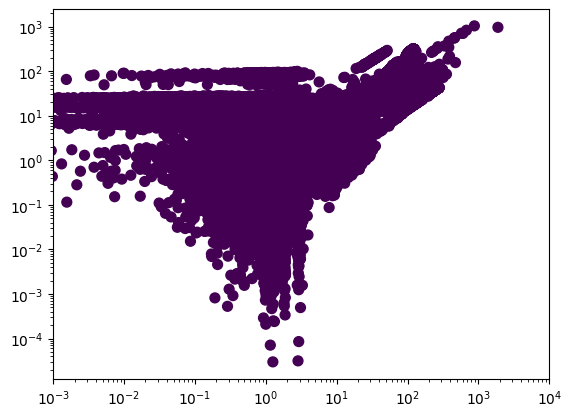

In [50]:
# visualize the transactions in the 2D space
plt.scatter(x_train_representation[:, 0], x_train_representation[:, 1], c=y_train.numpy(), s=50, cmap='viridis')
plt.xscale('log')
plt.yscale('log')

plt.xlim(10e-4,10e3)
#plt.ylim(0,400)

In [51]:
# Next try on validation data since that contains the frauds

x_valid_representation = []
for x_batch, y_batch in val_loader: 
    x_valid_representation.append(compute_representation(x_batch, small_model).detach().numpy())

x_valid_representation = np.vstack(x_valid_representation)

In [52]:
print(x_valid.shape)
print(x_valid_representation.shape)

torch.Size([134639, 169])
(134639, 2)


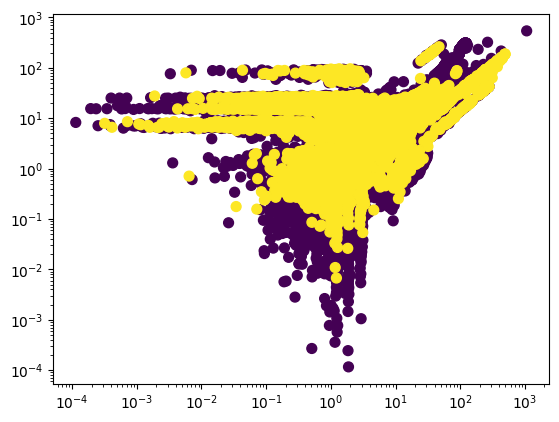

In [54]:
# visualize the transactions in the 2D space
plt.scatter(x_valid_representation[:, 0], x_valid_representation[:, 1], c=y_valid.numpy(), s=50, cmap='viridis')

plt.xscale('log')
plt.yscale('log')